# Comparsion of Isolation Forest anomaly scoring implementations by H2O, Sklearn and original paper

* IF = Isolation Forest
* EIF = Extended Isolation Forest

In [1]:
import sys
sys.path.append("D:/skola/dip/h2o-3/h2o-py/build") # path to h2o build
sys.path.append("D:/skola/dip/eif") # path to eif_old.py file (git clone https://github.com/sahandha/eif.git)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import eif_old as iso
import h2o
from h2o.estimators import H2OIsolationForestEstimator
from sklearn.ensemble import IsolationForest

versionFromGradle='3.27.0',projectVersion='3.27.0.99999',branch='PUBDEV-7138-extended-isolation-forest',lastCommitHash='623b47c7eb375cf6273a6c3ce067aa3b610f6cfb',gitDescribe='jenkins-master-4841-40-g623b47c7eb-dirty',compiledOn='2020-03-13 18:07:57',compiledBy='potte'


#### Note:
This notebook use old implementation of Extended Isolation Forest. The newest implementation is not working yet. Issue opened: https://github.com/sahandha/eif/issues/14

It should not affect the results.

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.60-b23, mixed mode)
  Starting server from D:\skola\dip\h2o-3\build\h2o.jar
  Ice root: C:\Users\potte\AppData\Local\Temp\tmpo8rmf6sp
  JVM stdout: C:\Users\potte\AppData\Local\Temp\tmpo8rmf6sp\h2o_potte_started_from_python.out
  JVM stderr: C:\Users\potte\AppData\Local\Temp\tmpo8rmf6sp\h2o_potte_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
versionFromGradle='3.27.0',projectVersion='3.27.0.99999',branch='PUBDEV-7138-extended-isolation-forest',lastCommitHash='623b47c7eb375cf6273a6c3ce067aa3b610f6cfb',gitDescribe='jenkins-master-4841-40-g623b47c7eb-dirty',compiledOn='2020-03-13 18:07:57',compiledBy='potte'


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Prague
H2O data parsing timezone:,UTC
H2O cluster version:,3.27.0.99999
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_potte_3tqex8
H2O cluster total nodes:,1
H2O cluster free memory:,21.27 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


# Single Blob
## Generate Data
Produce a single blob of 2-D data normally distributed with mean [0,0] and covariance of identity. We also add some outliers manually to the data for testing. 

In [4]:
mean = [0, 0]
cov = [[1, 0], [0, 1]]  # diagonal covariance
Nobjs = 500
np.random.seed(1)
x, y = np.random.multivariate_normal(mean, cov, Nobjs).T
#Add manual outlier
x[0]=3.3
y[0]=3.3
X=np.array([x,y]).T

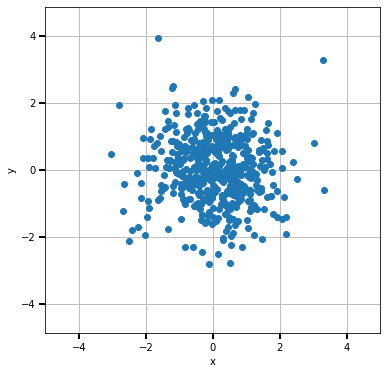

In [5]:
fig=plt.figure(figsize=(6,6))
fig.add_subplot(111)
plt.plot(X[:,0],X[:,1],'o')
plt.grid("off")
plt.axis("equal")
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel("x")
plt.ylabel("y")
plt.tick_params(direction='out', length=6, width=2)
plt.show()

### Create frames for each implementation

In [6]:
# h2o Training Frame
hf = h2o.H2OFrame(np.c_[x.ravel(), y.ravel()],column_names = ["x", "y"])

# Pandas Training Frame
df = hf.as_data_frame(use_pandas = True)
df.columns = ["x", "y"]

# Numpy Training Frame
X = np.array([x,y]).T

# Output - other data formats are similar
df.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,x,y
0,3.300000,3.300000
1,-0.528172,-1.072969
2,0.865408,-2.301539
3,1.744812,-0.761207
4,0.319039,-0.249370


### Train models

In [7]:
# Models training
seed = 1234
ntrees = 100

# H2O
IF_h2o = H2OIsolationForestEstimator(model_id = "isolation_forest.hex",
                                     ntrees = ntrees, seed = seed)
IF_h2o.train(training_frame = hf)

# Sklearn
IF_sklearn = IsolationForest(random_state = seed, contamination = "auto",
                    n_estimators = ntrees, behaviour="new")
IF_sklearn.fit(df)
print("Sklearn training done")

# Paper IF
IF_paper  = iso.iForest(X, ntrees = ntrees, sample_size = 256, ExtensionLevel=0)
print("Paper model IF training done")

# Paper EIF
EIF_paper  = iso.iForest(X, ntrees = ntrees, sample_size = 256, ExtensionLevel=1)
print("Paper model EIF training done")

isolationforest Model Build progress: |███████████████████████████████████| 100%


C:\Users\potte\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\ensemble\_iforest.py:245: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  warn(


Sklearn training done
Paper model IF training done
Paper model EIF training done


### Create data for map

In [8]:
granularity = 30

# Heat map data 
xx, yy = np.meshgrid(np.linspace(-5., 5., granularity), np.linspace(-5., 5, granularity))

# H2O
hf_heatmap = h2o.H2OFrame(np.c_[xx.ravel(), yy.ravel()], column_names = ["x", "y"]) 

# Pandas
df_heatmap = hf_heatmap.as_data_frame(use_pandas=True)

# Numpy
X_heatmap = np.c_[xx.ravel(), yy.ravel()]

# Output - other data formats are similar
df_heatmap.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,x,y
0,-5.000000,-5.0
1,-4.655172,-5.0
2,-4.310345,-5.0
3,-3.965517,-5.0
4,-3.620690,-5.0


### Compute anomaly score
#### Note:
Negative number of H2O mean length will be used and positive value of sklearn anomaly score

In [9]:
# Anomaly score for heatmap data

# H2O
h2o_anomaly_score = IF_h2o.predict(hf_heatmap).cbind(hf_heatmap)
h2o_anomaly_score_df = h2o_anomaly_score.as_data_frame(use_pandas=True, header=True)
heatmap_h2o = np.array(h2o_anomaly_score_df["predict"]).reshape(xx.shape)
heatmap_h2o_mean_length = -1*np.array(h2o_anomaly_score_df["mean_length"]).reshape(xx.shape)

# Sklearn
sklearn_anomaly_score = abs(IF_sklearn.score_samples(df_heatmap)) # Sklearn gives negative metrict of the same as 
                                                                 # it is in paper
heatmap_sklearn = sklearn_anomaly_score.reshape(xx.shape)
print("Sklearn anomaly scoring done")

# Paper IF
paper_anomaly_score_if = IF_paper.compute_paths(X_heatmap)
heatmap_paper_if = paper_anomaly_score_if.reshape(xx.shape)
print("Paper IF anomaly scoring done")

# Paper EIF
paper_anomaly_score_eif = EIF_paper.compute_paths(X_heatmap)
heatmap_paper_eif = paper_anomaly_score_eif.reshape(xx.shape)
print("Paper EIF anomaly scoring done")

# H2O EIF
h2o_anomaly_score_eif = pd.read_csv("eif-data/eif_fix_100.csv")
heatmap_h2o_eif = np.array(h2o_anomaly_score_eif["anomaly_score"]).reshape(xx.shape)
print("H2O EIF anomaly scoring done")

isolationforest prediction progress: |████████████████████████████████████| 100%
Sklearn anomaly scoring done
Paper IF anomaly scoring done
Paper EIF anomaly scoring done
H2O EIF anomaly scoring done


### Plot anomaly score

* Mean length = Mean path lengt through the forest to separate an observation. 

H2O plot has a white spots because all colorbars are between [0,1] but h2o has inconsistent anomaly score. It can be higher than 1 and lower than 0.

Sklear and paper implementation of IF/EIF use anomaly score normalization from the paper. [1] [2]

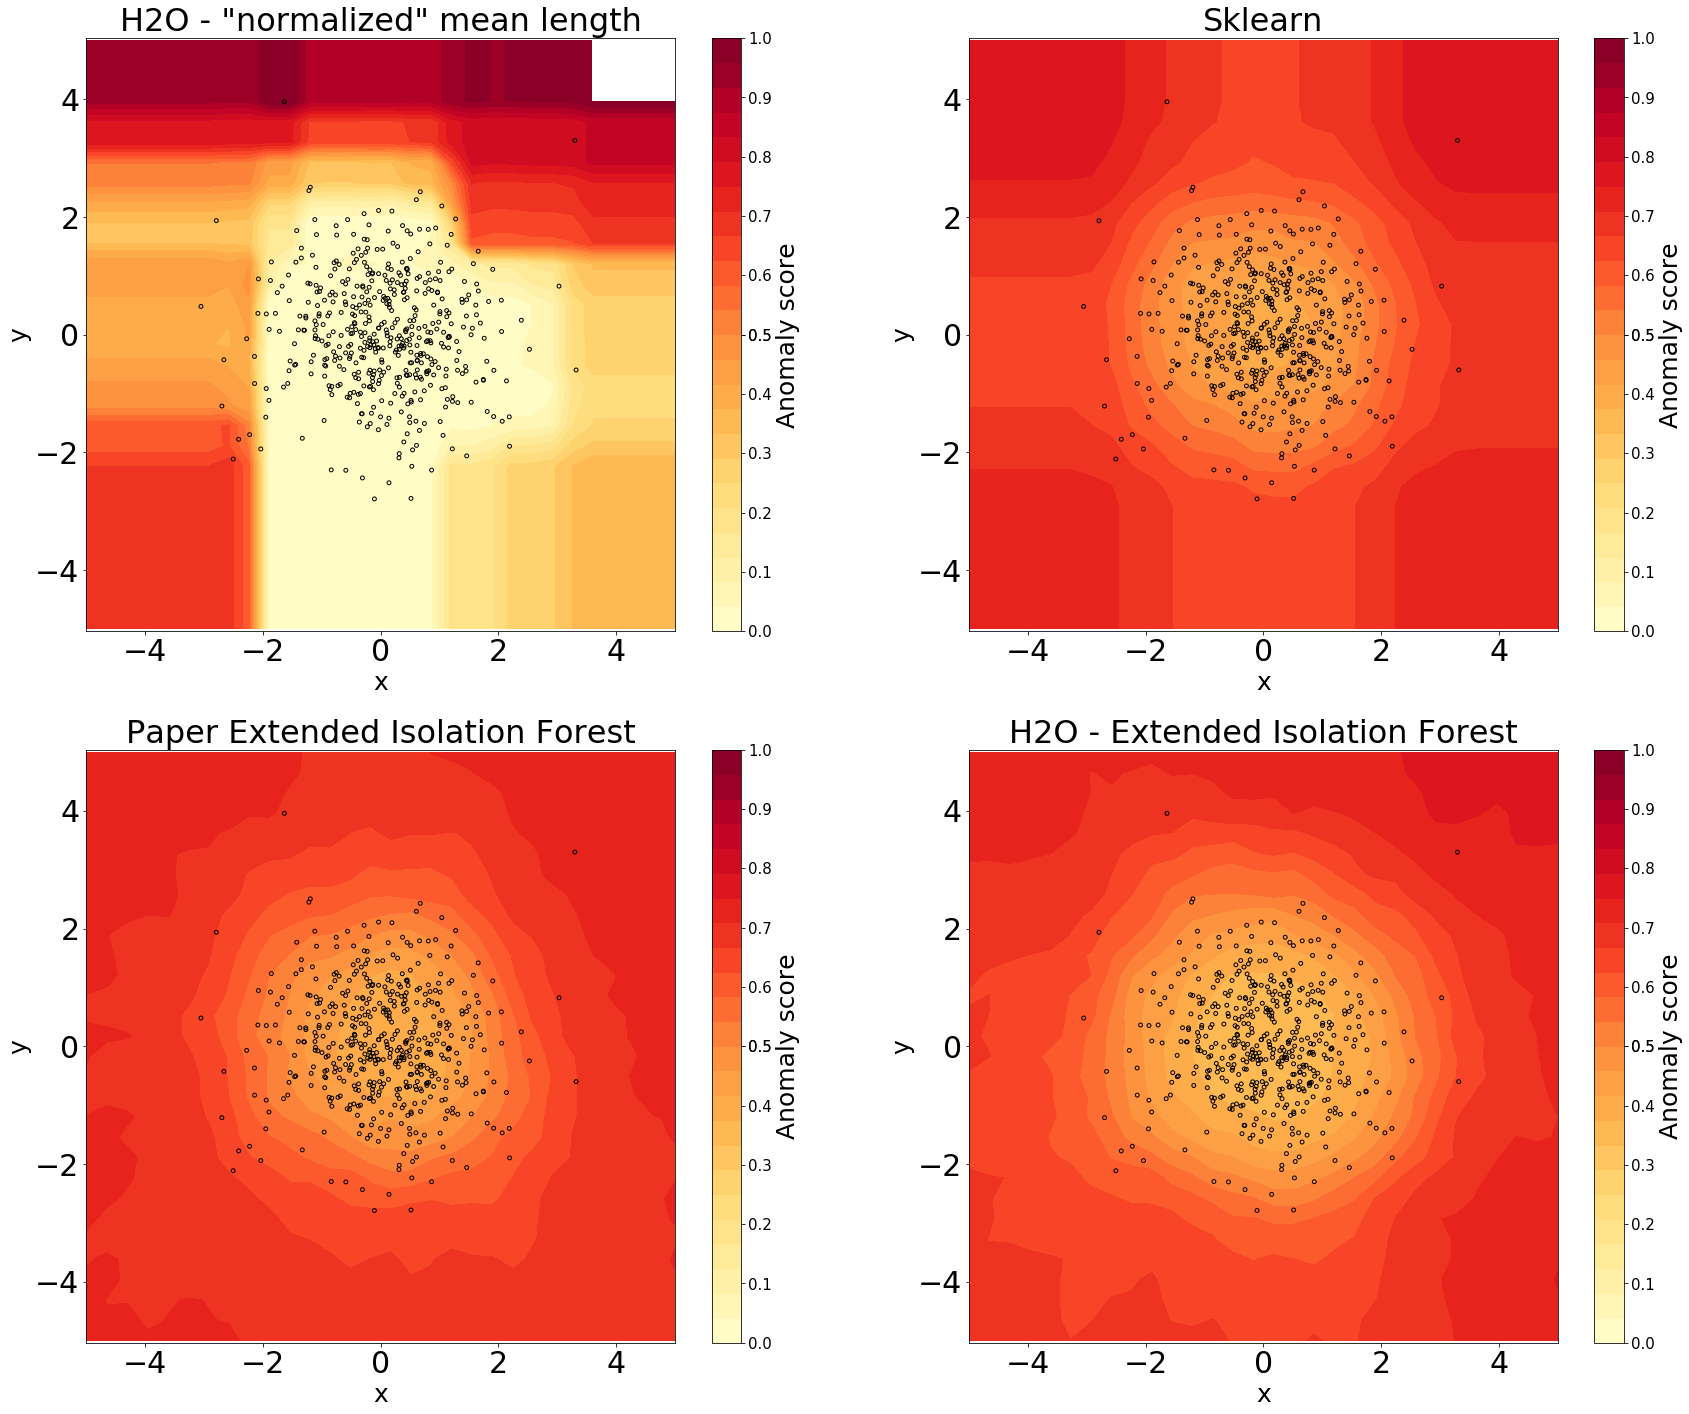

In [10]:
f = plt.figure(figsize=(29,24))

def plot_heatmap(heatmap_data, subplot, title): 

    ax1 = f.add_subplot(subplot)
    levels = np.linspace(0,1,25, endpoint=True)
    v = np.linspace(0, 1, 12, endpoint=True)
    v = np.around(v, decimals=1)
    CS = ax1.contourf(xx, yy, heatmap_data, levels, cmap=plt.cm.YlOrRd)
    cbar = plt.colorbar(CS, ticks=v)
    cbar.ax.set_ylabel('Anomaly score', fontsize = 25)
    cbar.ax.tick_params(labelsize=15)
    ax1.set_xlabel("x", fontsize = 25)
    ax1.set_ylabel("y", fontsize = 25)
    plt.tick_params(labelsize=30)
    plt.scatter(x,y,s=15,c='None',edgecolor='k')
    plt.axis("equal")
    plt.title(title,  fontsize=32)
    
plot_heatmap(heatmap_h2o, 221, "H2O - \"normalized\" mean length")
plot_heatmap(heatmap_sklearn, 222, "Sklearn")
plot_heatmap(heatmap_paper_eif, 223, "Paper Extended Isolation Forest")
plot_heatmap(heatmap_h2o_eif, 224, "H2O - Extended Isolation Forest")

plt.show()

### Plot also H2O mean length values 

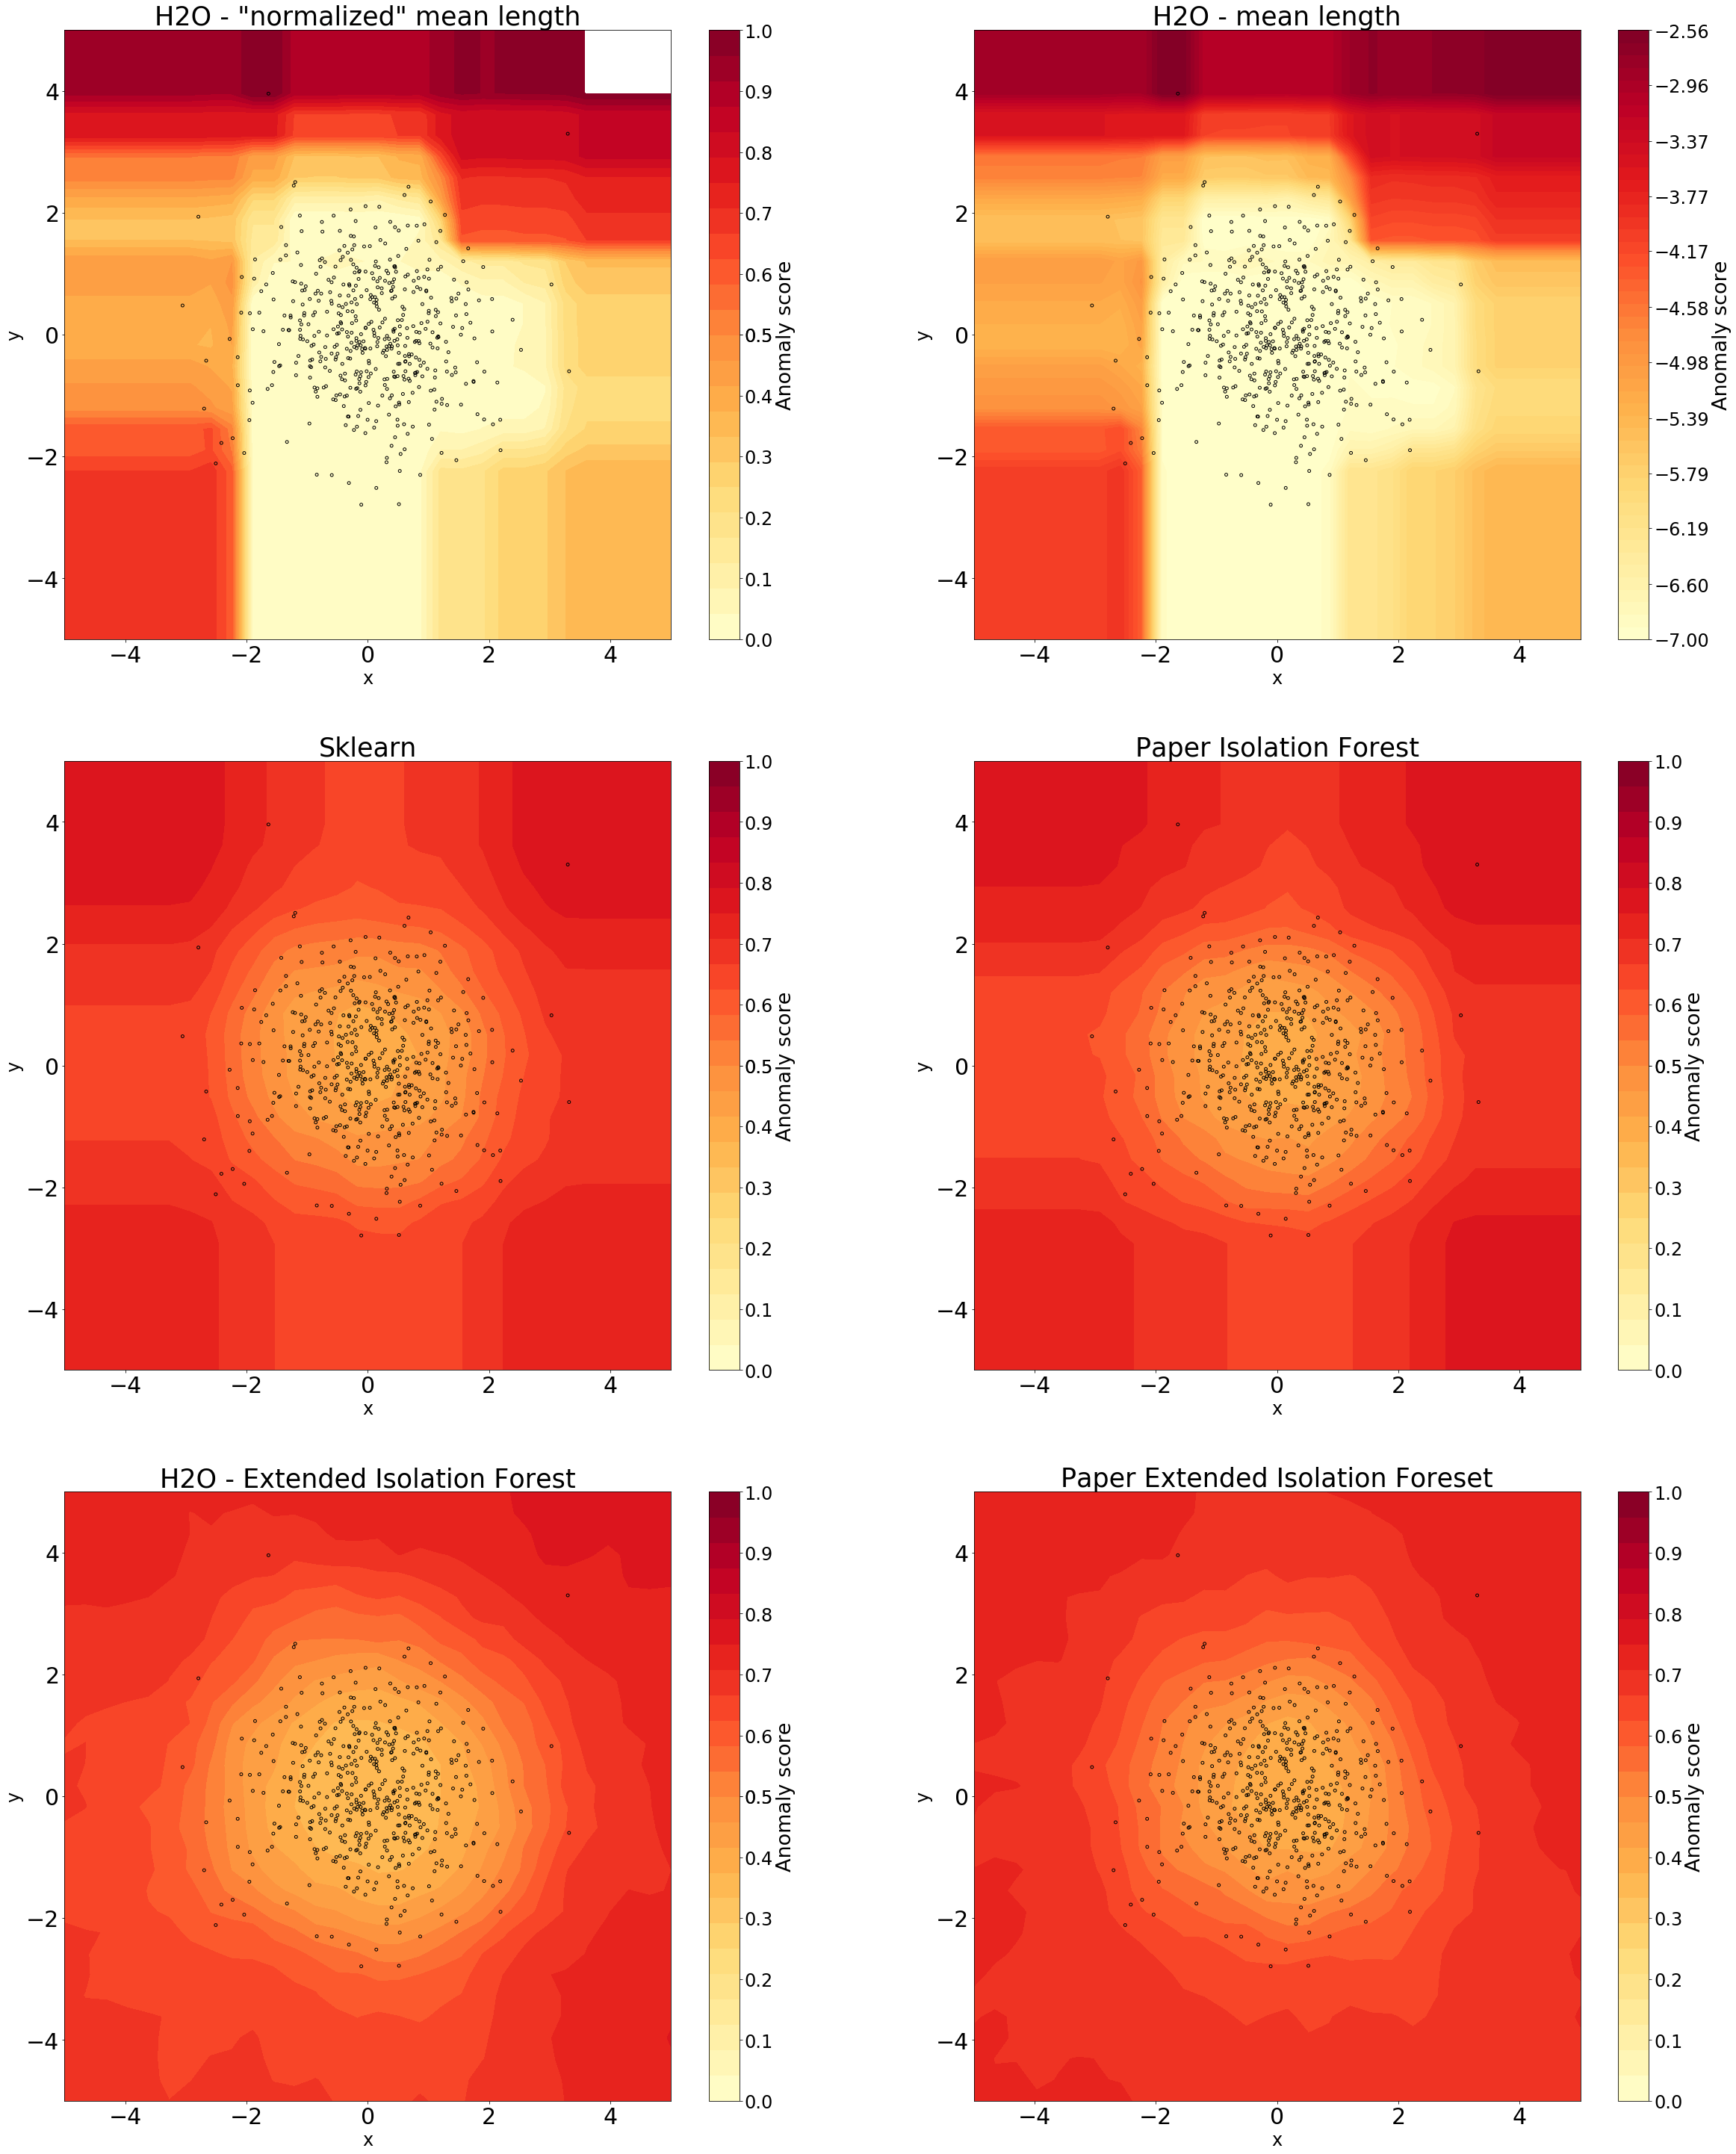

In [11]:
f = plt.figure(figsize=(40,51))

def plot_heatmap(heatmap_data, subplot, title): 

    ax1 = f.add_subplot(subplot)
    levels = np.linspace(0,1,25, endpoint=True)
    v = np.linspace(0, 1, 12, endpoint=True)
    v = np.around(v, decimals=1)
    CS = ax1.contourf(xx, yy, heatmap_data, levels, cmap=plt.cm.YlOrRd)
    cbar = plt.colorbar(CS, ticks=v)
    cbar.ax.set_ylabel('Anomaly score', fontsize = 27)
    cbar.ax.tick_params(labelsize=24)
    ax1.set_xlabel("x", fontsize = 24)
    ax1.set_ylabel("y", fontsize = 24)
    plt.tick_params(labelsize=30)
    plt.scatter(x,y,s=15,c='None',edgecolor='k')
    plt.axis("equal")
    plt.title(title,  fontsize=35)
    
# H2O
plot_heatmap(heatmap_h2o, 321, "H2O - \"normalized\" mean length")

# H2O - Mean length
ax1 = f.add_subplot(322)
levels = np.linspace(np.min(heatmap_h2o_mean_length), np.max(heatmap_h2o_mean_length),50, endpoint=True)
v = np.linspace(np.min(heatmap_h2o_mean_length), np.max(heatmap_h2o_mean_length),12, endpoint=True)
v = np.around(v, decimals = 2)
CS = ax1.contourf(xx, yy, heatmap_h2o_mean_length, levels, cmap=plt.cm.YlOrRd)
cbar = plt.colorbar(CS, ticks = v)
cbar.ax.set_ylabel('Anomaly score', fontsize = 27)
cbar.ax.tick_params(labelsize=24)
ax1.set_xlabel("x", fontsize = 24)
ax1.set_ylabel("y", fontsize = 24)
plt.tick_params(labelsize=30)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.axis("equal")
plt.title("H2O - mean length",  fontsize=35)

plot_heatmap(heatmap_sklearn, 323, "Sklearn")
plot_heatmap(heatmap_paper_if, 324, "Paper Isolation Forest")
plot_heatmap(heatmap_h2o_eif, 325, "H2O - Extended Isolation Forest")
plot_heatmap(heatmap_paper_eif, 326, "Paper Extended Isolation Foreset")

plt.show()

In [12]:
hf44 = h2o.H2OFrame([[4,4],[4,-4]], column_names = ["x", "y"]) 

predictions44 = IF_h2o.predict(hf44).cbind(hf44)
dfp44 = predictions44.as_data_frame(use_pandas=True, header=True)
dfp44

Parse progress: |█████████████████████████████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


,predict,mean_length,x,y
0,1.004525,2.56,4,4
1,0.366516,5.38,4,-4


### Conclusion

H2O implementation has inconsistend anomaly score computation to sklearn or paper. H2O anomaly score is not eualy distributet as it is in others. For example point (4,4) and (4,-4) are both anomalies but their score is 
* (4, 4) - anomaly score = 1.071233, mean length = 3.09
* (4,-4) - anomaly score = 0.652055, mean length = 4.62

the gap between those two points is too large to decide by anomaly score. The score is not equaly distributed though dataset.

* Sklear anomaly score calculation is [here](https://github.com/scikit-learn/scikit-learn/blob/bf24c7e3d6d768dddbfad3c26bb3f23bc82c0a18/sklearn/ensemble/_iforest.py#L463).
* Paper anomaly score calculation is [here](https://github.com/sahandha/eif/blob/master/eif_old.py#L130).

## References

1. Sklearn anomaly score: https://github.com/scikit-learn/scikit-learn/blob/bf24c7e3d6d768dddbfad3c26bb3f23bc82c0a18/sklearn/ensemble/_iforest.py#L463
2. Paper EIF anomaly score: https://github.com/sahandha/eif/blob/master/eif_old.py#L130
3. Paper EIF implementation: https://github.com/sahandha/eif/
4. Sklearn IF documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest.score_samples